##### Set directory

In [1]:
%cd 

##### Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import seaborn as sns

from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.feature_selection import RFECV

import optuna
from optuna.samplers import TPESampler

##### Import data, general description

In [3]:
path = ''
poll = pd.read_csv(path+"ACME-HappinessSurvey2020.csv")

print('\nThe 5 first poll answers are:\n')
print(poll.head())
print('\n Description of the poll dataset:\n')
print(poll.describe())


The 5 first poll answers are:

   Y  X1  X2  X3  X4  X5  X6
0  0   3   3   3   4   2   4
1  0   3   2   3   5   4   3
2  1   5   3   3   3   3   5
3  0   5   4   3   3   3   5
4  0   5   4   3   3   3   5

 Description of the poll dataset:

                Y          X1          X2          X3          X4          X5  \
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000   
mean     0.547619    4.333333    2.531746    3.309524    3.746032    3.650794   
std      0.499714    0.800000    1.114892    1.023440    0.875776    1.147641   
min      0.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      0.000000    4.000000    2.000000    3.000000    3.000000    3.000000   
50%      1.000000    5.000000    3.000000    3.000000    4.000000    4.000000   
75%      1.000000    5.000000    3.000000    4.000000    4.000000    4.000000   
max      1.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

               X6  
count  1

##### Split into train and test sets

In [4]:
X = poll.drop('Y', axis = 'columns')
y = poll['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

##### Hyperparameter tuning with optuna

In [5]:
### Training with XGBoost. Hyperparameter tuning

def objective(trial): # The objective to maximize in the optuna study
    n_estimators = trial.suggest_int("n_estimators", 1, 50)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 5)
    _XGB_model = XGBClassifier(objective = 'binary:logistic', eval_metric = 'error', learning_rate = learning_rate, 
                               max_depth = max_depth, n_estimators = n_estimators, random_state = 0)
    _XGB_model.fit(X_train, y_train)
    return _XGB_model.score(X_test, y_test)

sampler = TPESampler(seed=0)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

print("\nNumber of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

learning_rate = trial.params['learning_rate']
max_depth = trial.params['max_depth']
n_estimators = trial.params['n_estimators']

[I 2023-05-15 15:54:31,003] A new study created in memory with name: no-name-be70bcf4-ec89-42c6-aae7-2b05645323f1
[I 2023-05-15 15:54:31,020] Trial 0 finished with value: 0.5384615384615384 and parameters: {'n_estimators': 28, 'learning_rate': 0.051902630176951646, 'max_depth': 4}. Best is trial 0 with value: 0.5384615384615384.
[I 2023-05-15 15:54:31,032] Trial 1 finished with value: 0.5769230769230769 and parameters: {'n_estimators': 28, 'learning_rate': 0.02652496376759476, 'max_depth': 4}. Best is trial 1 with value: 0.5769230769230769.
[I 2023-05-15 15:54:31,045] Trial 2 finished with value: 0.5384615384615384 and parameters: {'n_estimators': 22, 'learning_rate': 0.0779422611516095, 'max_depth': 5}. Best is trial 1 with value: 0.5769230769230769.
[I 2023-05-15 15:54:31,058] Trial 3 finished with value: 0.6923076923076923 and parameters: {'n_estimators': 20, 'learning_rate': 0.06190490166774187, 'max_depth': 3}. Best is trial 3 with value: 0.6923076923076923.
[I 2023-05-15 15:54:31

[I 2023-05-15 15:54:31,822] Trial 36 finished with value: 0.5769230769230769 and parameters: {'n_estimators': 31, 'learning_rate': 0.04896004301570633, 'max_depth': 2}. Best is trial 17 with value: 0.7307692307692307.
[I 2023-05-15 15:54:31,848] Trial 37 finished with value: 0.6538461538461539 and parameters: {'n_estimators': 26, 'learning_rate': 0.058045046508329735, 'max_depth': 3}. Best is trial 17 with value: 0.7307692307692307.
[I 2023-05-15 15:54:31,873] Trial 38 finished with value: 0.5769230769230769 and parameters: {'n_estimators': 9, 'learning_rate': 0.0816463675009382, 'max_depth': 4}. Best is trial 17 with value: 0.7307692307692307.
[I 2023-05-15 15:54:31,898] Trial 39 finished with value: 0.5384615384615384 and parameters: {'n_estimators': 23, 'learning_rate': 0.030284559885595447, 'max_depth': 5}. Best is trial 17 with value: 0.7307692307692307.
[I 2023-05-15 15:54:31,922] Trial 40 finished with value: 0.5 and parameters: {'n_estimators': 7, 'learning_rate': 0.02665199301


Number of finished trials:  50
Best trial:
  Value:  0.7307692307692307
  Params: 
    n_estimators: 21
    learning_rate: 0.058425813128117225
    max_depth: 3


##### Training the model

In [6]:
# XGBoost XGB_model with tuned parameters
XGB_model = XGBClassifier(objective = 'binary:logistic', eval_metric = 'error', learning_rate = learning_rate, 
                          max_depth = max_depth, n_estimators = n_estimators, random_state = 0)

# The tuning should have returned: XGB_model = XGBClassifier(objective = 'binary:logistic', eval_metric = 'error', 
# learning_rate = 0.0584, max_depth = 3, n_estimators = 21)

XGB_model.fit(X_train, y_train)
y_hat = XGB_model.predict(X_test)
print('\nThe XGB_model score on the test set is: ', XGB_model.score(X_test, y_test))
print(classification_report(y_test, y_hat))

print('\nImportance of each feature using this XGB_model:\n')
selector = RFECV(XGB_model, step=1, cv=5, min_features_to_select = 1)

selector = selector.fit(X_train, y_train)
for j in range(X.shape[1]):
    print(f'The variable X{j+1} was selected: ', selector.support_[j])
for j in range(X.shape[1]):
    print(f'Rank of variable X{j+1}: ', selector.ranking_[j])

X_train_reduced = X_train[['X1', 'X3']]
XGB_model.fit(X_train_reduced, y_train)
y_hat = XGB_model.predict(X_test[['X1', 'X3']])
print('\nThe XGB_model score on the test set using only X1 and X3 features is: ', XGB_model.score(X_test[['X1', 'X3']], y_test))
print(classification_report(y_test, y_hat))

X_train_reduced = X_train[['X1']]
XGB_model.fit(X_train_reduced, y_train)
y_hat = XGB_model.predict(X_test[['X1']])
print('The XGB_model score on the test set using only X1 feature is: ', XGB_model.score(X_test[['X1']], y_test))
print(classification_report(y_test, y_hat))


The XGB_model score on the test set is:  0.7307692307692307
              precision    recall  f1-score   support

           0       0.80      0.62      0.70        13
           1       0.69      0.85      0.76        13

    accuracy                           0.73        26
   macro avg       0.74      0.73      0.73        26
weighted avg       0.74      0.73      0.73        26


Importance of each feature using this XGB_model:

The variable X1 was selected:  True
The variable X2 was selected:  False
The variable X3 was selected:  True
The variable X4 was selected:  False
The variable X5 was selected:  False
The variable X6 was selected:  False
Rank of variable X1:  1
Rank of variable X2:  4
Rank of variable X3:  1
Rank of variable X4:  5
Rank of variable X5:  3
Rank of variable X6:  2

The XGB_model score on the test set using only X1 and X3 features is:  0.7307692307692307
              precision    recall  f1-score   support

           0       0.75      0.69      0.72        

##### Predictions

In [11]:
XGB_model = XGBClassifier(objective = 'binary:logistic', eval_metric = 'error', learning_rate = 0.0584, max_depth = 3,
                          n_estimators = 21, random_state = 0)

## Choose number of variables used (1, 2 or 6):
number = 6

if number == 6:
    XGB_model.fit(np.array(X_train), np.array(y_train))
    score = XGB_model.score(X_test, y_test)

elif number == 2:
    XGB_model.fit(np.array(X_train[['X1', 'X3']]), np.array(y_train))
    score = XGB_model.score(X_test[['X1', 'X3']], y_test)
    predictions = np.zeros((5,5))
    for i in range(1, 6):
        for j in range(1, 6):
            predictions[i-1][j-1] = XGB_model.predict([[j, i]])[0]
    sns.heatmap(predictions)
    plt.xlabel('X1 - 1')
    plt.ylabel('X3 - 1')
    plt.title('Model predictions from variables X1 and X3')
    plt.show()

elif number == 1:
    XGB_model.fit(np.array(X_train[['X1']]), np.array(y_train))
    print('The model prediction for X1 = 5 is ', XGB_model.predict([[5]])[0])
    print('The model prediction for X1 <= 4 is ', XGB_model.predict([[4]])[0])
    assert XGB_model.predict([[3]])[0] == XGB_model.predict([[2]])[0] == XGB_model.predict([[1]])[0] == 0

print(f'\nThe XGB_model score on the test set using {number} feature(s) is: {score}')

# The model score is identical if only X1 is chosen, or if more variable were chosen (73%)
# Therefore X1 is the only meaningful variable for this model
XGB_model.fit(np.array(X[['X1']]), np.array(y))

## set a new X_test, y_test dataset
X_test = X_test
y_test = y_test

print('\nThe XGB_model score on the test set using only X1 feature is: ', XGB_model.score(X_test[['X1']], y_test))

print('The model predicts y = 1 if and only if X1 = 5')


The XGB_model score on the test set using 6 feature(s) is: 0.7307692307692307

The XGB_model score on the test set using only X1 feature is:  0.7307692307692307
The model predicts y = 1 if and only if X1 = 5


##### Data visualization and interpretation

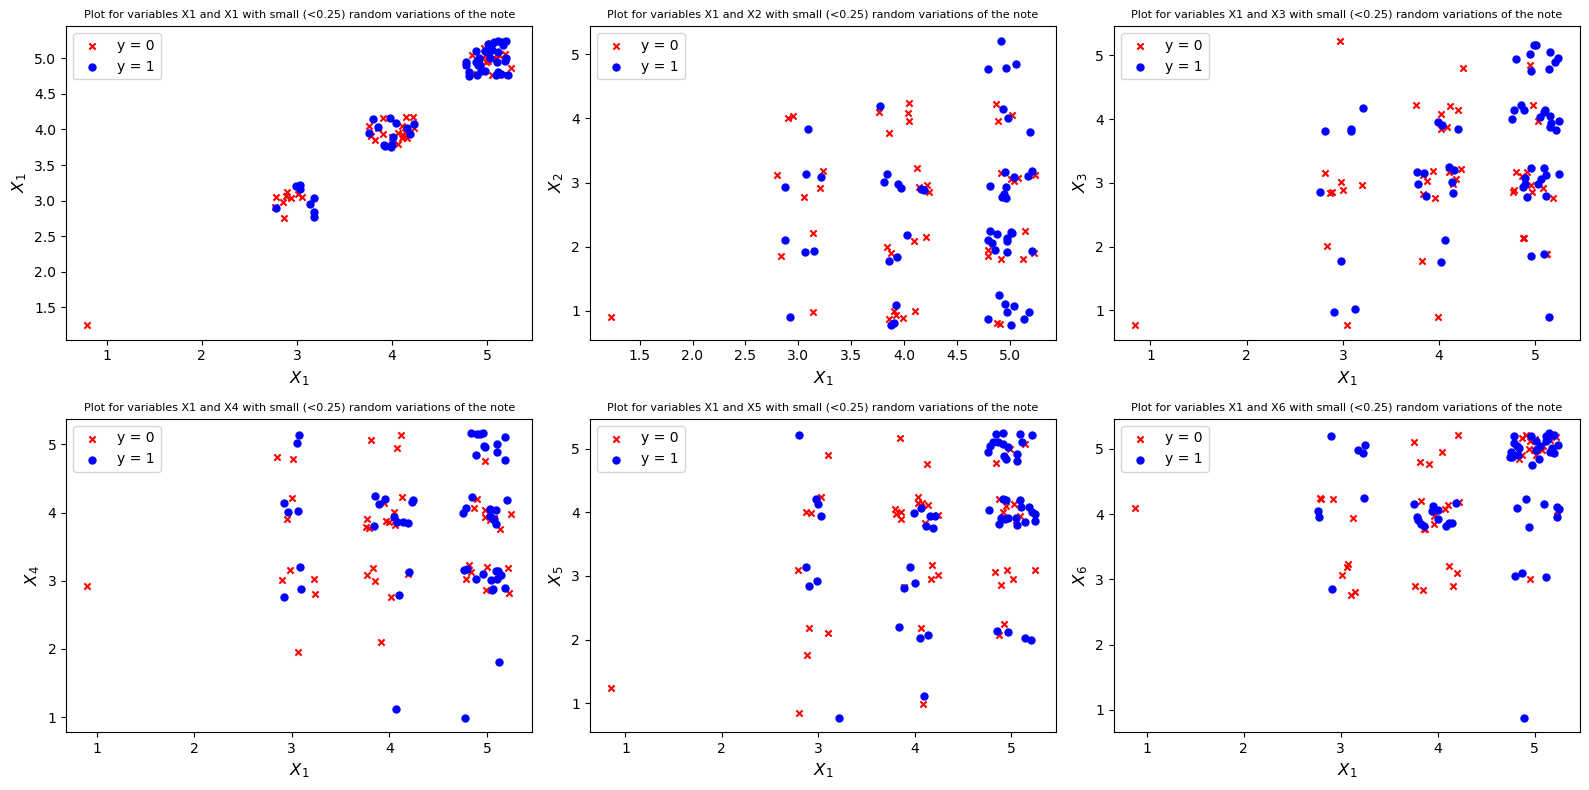

In [12]:
fig, ax = plt.subplots(2, 3, figsize = (16,8))
m, n = X_train.shape

neg = y_train == 0
pos = y_train == 1


for k in range(6):
    x_neg, y_neg = np.array(X_train[['X%s'%1]][neg], dtype = 'float64').reshape(-1), np.array(X_train[['X%s'%(k+1)]][neg], dtype = 'float64').reshape(-1)
    x_pos, y_pos = np.array(X_train[['X%s'%1]][pos], dtype = 'float64').reshape(-1), np.array(X_train[['X%s'%(k+1)]][pos], dtype = 'float64').reshape(-1)

    move = 0.25
    x_neg += np.random.uniform(-move,move, size = len(x_neg))
    y_neg += np.random.uniform(-move,move, size = len(x_neg))

    x_pos += np.random.uniform(-move,move, size = len(x_pos))
    y_pos += np.random.uniform(-move,move, size = len(x_pos))
    i, j = k//3, k%3
    ax[i][j].scatter(x_neg, y_neg, marker = 'x', c = 'red', s = 20, label = 'y = 0')
    ax[i][j].scatter(x_pos, y_pos , marker = 'o', c = 'blue', s = 25, label = 'y = 1')
    ax[i][j].set_ylabel('$X_%s$'%(k+1), fontsize = 12)
    ax[i][j].set_xlabel('$X_1$', fontsize = 12)
    ax[i][j].set_title('Plot for variables X1 and X%s with small (<%s) random variations of the note'%(k+1, move), fontsize = 8)
    ax[i][j].legend()
    plt.tight_layout()

plt.show()

The data above is plotted as as function of X1 and one other variable, uniformly distributing the training examples around their original note (variation <0.25) for better visualization. This is to visually inspect why the XGBoost results for X1 and another feature do not yield a better score than for just X1.